In [209]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
import importlib
import math
import torchvision
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

Modules loaded
Reload complete
GPUs available: 1


In [210]:
resplit_data = True
if resplit_data:
    os.system('python3 utils/splitDataFolder.py -r "data/GroundTruth_052219/" -c "data/GroundTruth_052219/Label_1_removeDouble.csv" -s 0.15')
    
print("fin")

fin


In [211]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,28,28))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    normalized = False
    #util.visualizeBatch(data_loader, normalized)
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    #criterion = loss(None)
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=.1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()


In [212]:
config_file = 'config_groundTruth.json'


# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [213]:
#Train the network
main(config, None)

Total number of training images = 477
heatmapModel(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=12544, out_features=1000, bia

Train Epoch: 1 [0/406 (0%)] Loss: 0.713672
Train Epoch: 1 [160/406 (38%)] Loss: 4.455962
Train Epoch: 1 [320/406 (77%)] Loss: 1.811397
    epoch          : 1
    loss           : 1.918108458702381
    my_metric      : 0.6289335664335665
    val_loss       : 2.6311355431874595
    val_my_metric  : 0.6071428571428571
Saving checkpoint: saved/GroundTruth_cellData/0603_202554/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
Train Epoch: 2 [0/406 (0%)] Loss: 2.045232
Train Epoch: 2 [160/406 (38%)] Loss: 0.230863
Train Epoch: 2 [320/406 (77%)] Loss: 0.484094
    epoch          : 2
    loss           : 0.836345218695127
    my_metric      : 0.7036713286713288
    val_loss       : 0.5982963442802429
    val_my_metric  : 0.6904761904761904
Saving checkpoint: saved/GroundTruth_cellData/0603_202554/checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
Train Epoch: 3 [0/406 (0%)] Loss: 0.575739
Train Epoch: 3 [160/406 (38%)] Loss: 0.485234
Train Epoch: 3 [320/406 (77%)

Train Epoch: 24 [0/406 (0%)] Loss: 0.321569
Train Epoch: 24 [160/406 (38%)] Loss: 0.272762
Train Epoch: 24 [320/406 (77%)] Loss: 0.236540
    epoch          : 24
    loss           : 0.3429717513231131
    my_metric      : 0.7784090909090909
    val_loss       : 0.5183798670768738
    val_my_metric  : 0.8020833333333334
Train Epoch: 25 [0/406 (0%)] Loss: 0.304600
Train Epoch: 25 [160/406 (38%)] Loss: 0.561219
Train Epoch: 25 [320/406 (77%)] Loss: 0.291458
    epoch          : 25
    loss           : 0.3728403930480664
    my_metric      : 0.7784090909090909
    val_loss       : 0.46887819468975067
    val_my_metric  : 0.7544642857142857
Train Epoch: 26 [0/406 (0%)] Loss: 0.249279
Train Epoch: 26 [160/406 (38%)] Loss: 0.366627
Train Epoch: 26 [320/406 (77%)] Loss: 0.453716
    epoch          : 26
    loss           : 0.3555867224931717
    my_metric      : 0.7738199300699301
    val_loss       : 0.47240562240282696
    val_my_metric  : 0.7916666666666666
Train Epoch: 27 [0/406 (0%)] Los

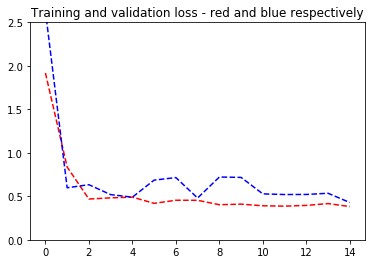

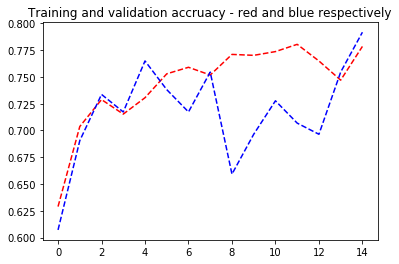

done


In [214]:
#log_dir = 'saved/runs/GroundTruth_cellData/0530_184531/'
saved_dir = 'saved/GroundTruth_cellData/0603_202554'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir) #imported from utils

print('done')

In [215]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('class0', 'class1')
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                util.visualizationOutGray(data, output, target, classes, normalized)
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        plt.show()
                      
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    print(log)
    print("My_metric is accuracy")
    
   

In [216]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/83 [00:00<?, ?it/s]

heatmapModel(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=12544, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linea

100%|██████████| 83/83 [00:00<00:00, 160.94it/s]


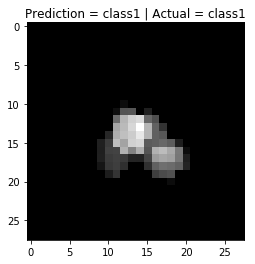

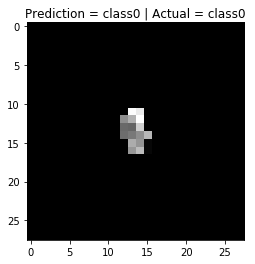

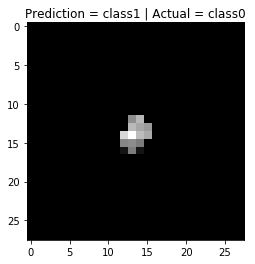

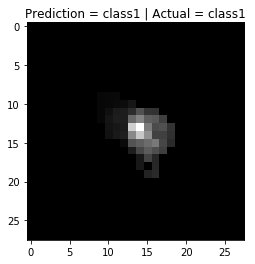

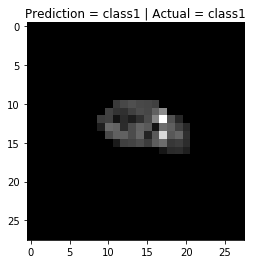

num samples = 83
{'loss': 0.6848057605415941, 'my_metric': 0.7228915662650602}
My_metric is accuracy


In [217]:
#Test
main2(config, resume)